In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, f1_score, \
                            mean_squared_error, roc_curve, roc_auc_score 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
import re
import time
from datetime import datetime, timedelta
import requests as r
import matplotlib.pyplot as plt

In [2]:
#In the prior notebook, we scraped performance and weather data and saved the csv
#We're now going to use data to train a model
#Afterwards, we'll collect current performance, weather, and betting data to predict which teams will cover

In [3]:
reg_data = pd.read_csv('/Users/SwagMawi/Documents/GitHub/projects/PredictingNFLGames/training_data_2023.csv')

In [4]:
reg_data.columns = [str(i) for i in reg_data.columns]

In [5]:
#Confirming the CSV maintains the rolling behavior of skipping the first 2 weeks

reg_data.sort_values(by=['Year', 'Team', 'Week']).iloc[14:20,30:45]

,Rolling_Strength,Opp_Scoring_Spread,Opp_Rolling_Strength,Rolling_Off1stD,Rolling_OffTotYd,Rolling_OffPassY,Rolling_OffRushY,Rolling_OffTO,Rolling_Def1stD,Rolling_DefTotYd,Rolling_DefPassY,Rolling_DefRushY,Rolling_DefTO,Opp_Rolling_Off1stD,Opp_Rolling_OffTotYd
57,3.38,-11.0,-0.69,22.666667,422.000000,294.666667,127.333333,1.666667,19.333333,326.333333,185.666667,140.666667,1.333333,23.666667,400.000000
400,2.53,76.0,4.47,20.333333,363.333333,273.000000,90.333333,2.000000,23.000000,384.333333,233.000000,151.333333,1.000000,19.000000,323.333333
450,-13.00,13.0,13.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201,-7.00,-2.0,-1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,-6.00,12.0,4.00,24.000000,419.000000,309.333333,109.666667,1.000000,26.333333,463.333333,350.333333,113.000000,1.666667,22.666667,368.000000
500,-8.00,51.0,12.75,22.666667,359.333333,247.666667,111.666667,0.333333,26.333333,470.000000,355.666667,114.333333,1.666667,24.000000,420.000000


In [6]:
#Let's add a column for whether or not a team is favored
#Based on historical data, favorites only cover ~44% of the time
#The fact that a team is even favored to win isn't affecting their performance
#But it could mean the betting market over-estimates the winning margin, causing favorites not to cover

In [7]:
reg_data['is_fav'] = np.where(reg_data['Betting Spread'] < 0, 1, 0)

In [8]:
#Getting rid of weeks w/o data

reg_data = reg_data.dropna()

In [9]:
reg_data.columns

Index(['Unnamed: 0', 'Week', 'Day', 'Date', 'Time', 'boxscore', 'Result', 'OT',
       'Rec', 'Home/Away', 'Opp Name', 'Team Score', 'Opp Score', 'Off1stD_x',
       'OffTotYd_x', 'OffPassY_x', 'OffRushY_x', 'OffTO_x', 'Def1stD_x',
       'DefTotYd_x', 'DefPassY_x', 'DefRushY_x', 'DefTO_x', 'Offense',
       'Defense', 'Sp. Tms', 'Team', 'Year', 'Team_Scoring_Spread',
       'Rolling_Scoring_Spread', 'Rolling_Strength', 'Opp_Scoring_Spread',
       'Opp_Rolling_Strength', 'Rolling_Off1stD', 'Rolling_OffTotYd',
       'Rolling_OffPassY', 'Rolling_OffRushY', 'Rolling_OffTO',
       'Rolling_Def1stD', 'Rolling_DefTotYd', 'Rolling_DefPassY',
       'Rolling_DefRushY', 'Rolling_DefTO', 'Opp_Rolling_Off1stD',
       'Opp_Rolling_OffTotYd', 'Opp_Rolling_OffPassY', 'Opp_Rolling_OffRushY',
       'Opp_Rolling_OffTO', 'Opp_Rolling_Off1stD.1', 'Opp_Rolling_DefTotYd',
       'Opp_Rolling_DefPassY', 'Opp_Rolling_DefRushY', 'Opp_Rolling_DefTO',
       'Betting Spread', 'Datetime', 'Time_Rounded', 'H

In [224]:
X = reg_data[['Home/Away', 'Rolling_Scoring_Spread',
              'Opp_Rolling_Strength', 'Rolling_Strength', 'Rolling_Off1stD', 'Rolling_OffTotYd',
              'Rolling_OffPassY', 'Rolling_OffRushY', 'Rolling_OffTO', 'Rolling_Def1stD', 
              'Rolling_DefTotYd', 'Rolling_DefPassY', 'Rolling_DefRushY', 'Rolling_DefTO', 
              'Opp_Rolling_Off1stD','Opp_Rolling_OffTotYd', 'Opp_Rolling_OffPassY', 
              'Opp_Rolling_OffRushY', 'Opp_Rolling_OffTO', 'Opp_Rolling_DefTotYd',
              'Opp_Rolling_DefPassY', 'Opp_Rolling_DefRushY', 'Opp_Rolling_DefTO','is_intl',
              'Temp', 'Windspeed', '0', '1', '2', '3',
                             '51', '53', '55', '61',
                             '63', '71', '73', '75', 'is_fav']]

In [225]:
X.head()

,Home/Away,Rolling_Scoring_Spread,Opp_Rolling_Strength,Rolling_Strength,Rolling_Off1stD,Rolling_OffTotYd,Rolling_OffPassY,Rolling_OffRushY,Rolling_OffTO,Rolling_Def1stD,...,3,51,53,55,61,63,71,73,75,is_fav
1,1,27.0,-0.23,2.08,25.333333,383.333333,274.666667,108.666667,2.000000,24.666667,...,0,0,0,0,0,0,0,0,0,0
2,1,49.0,2.00,5.44,22.333333,394.666667,289.333333,105.333333,0.333333,19.000000,...,0,0,0,0,0,0,0,0,0,1
3,1,38.0,3.00,6.33,17.333333,326.666667,226.666667,100.000000,1.000000,17.666667,...,0,0,0,0,0,0,0,0,0,1
4,1,23.0,2.00,4.60,23.333333,381.666667,270.000000,111.666667,0.666667,22.333333,...,0,0,0,0,0,0,0,0,0,0
5,1,-23.0,9.00,-5.75,23.333333,336.000000,207.333333,128.666667,2.000000,26.333333,...,0,0,0,0,0,0,0,0,0,0


In [226]:
y = reg_data['Cover']

In [227]:
import plotly.express as px

In [228]:
#Visualize if features are highly correlated with one another

heat = px.imshow(X.corr(), text_auto=True)
heat.show()

In [229]:
#Overall these variables are not that closely related
#Only issue is Off1st Down, Off Total Yards, and Off Passing Yards are highly correlated to one another
#Which is interesting that rushing yards isn't
#One pass attempt likely gets more yards than a rush attempt, so it makes sense passing is more correlated
#This is a hypothesis, but this article from 2019 seems to suggest the same:
#https://www.footballperspective.com/distribution-of-passing-and-rushing-yards-by-play-in-2019

In [230]:
#Lets view these highly correlated features
X.corr().iloc[4:7,4:7]

,Rolling_Off1stD,Rolling_OffTotYd,Rolling_OffPassY
Rolling_Off1stD,1.000000,0.836089,0.655779
Rolling_OffTotYd,0.836089,1.000000,0.792973
Rolling_OffPassY,0.655779,0.792973,1.000000


In [231]:
#Let's add cover and see which of these 3 are most correlated to cover

reg_data[['Rolling_Off1stD',
'Rolling_OffTotYd',
'Rolling_OffPassY',
            'Cover']].corr().loc['Cover']

Rolling_Off1stD     0.139131
Rolling_OffTotYd    0.140425
Rolling_OffPassY    0.005249
Cover               1.000000
Name: Cover, dtype: float64

In [232]:
#Total yards is most correlated, so to reduce multicollinearity, we'll remove 'Rolling_Off1stD' and 'Rolling_OffPassY'

X = X.drop(['Rolling_Off1stD','Rolling_OffPassY'], axis=1)

In [233]:
#Again, the same thing for the def version of these features
#Let's confirm

reg_data[['Rolling_Def1stD',
'Rolling_DefTotYd',
'Rolling_DefPassY',
            'Cover']].corr().loc['Cover']

Rolling_Def1stD    -0.163419
Rolling_DefTotYd   -0.183733
Rolling_DefPassY   -0.063028
Cover               1.000000
Name: Cover, dtype: float64

In [234]:
#Let's keep 'Rolling_DefTotYd'
X = X.drop(['Rolling_Def1stD','Rolling_DefPassY'], axis=1)

In [235]:
#Noticing the same thing for the opponent version of these features
#Let's confirm

reg_data[['Opp_Rolling_Off1stD',
'Opp_Rolling_OffTotYd',
'Opp_Rolling_OffPassY',
            'Cover']].corr().loc['Cover']

Opp_Rolling_Off1stD    -0.140343
Opp_Rolling_OffTotYd   -0.144286
Opp_Rolling_OffPassY   -0.007006
Cover                   1.000000
Name: Cover, dtype: float64

In [236]:
#Again, 'Opp_Rolling_OffTotYd' has the highest correlation (absolute value), so it'll be kept
X = X.drop(['Opp_Rolling_Off1stD','Opp_Rolling_OffPassY'], axis=1)

In [237]:
#Now that we've steps to reduce multi-collinearity, let's train our model

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [239]:
#Let's create a modeling pipeline
#Essentially in one object we can scale and set up the model

In [240]:
reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1))
])

In [241]:
#Let's also set up our cross-evaluation method
#We'll use RMSE to score our regressor

In [242]:
cv_scores = cross_val_score(reg_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validated RMSE: {np.sqrt(-np.mean(cv_scores)):.2f}")

Cross-validated RMSE: 11.20


In [243]:
reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GradientBoostingRegressor())])

In [244]:
# Performance on test set
y_pred = reg_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Validation RMSE: {rmse:.2f}")

Validation RMSE: 10.76


In [31]:
#Let's see feature importances

In [32]:
importance = list(zip(X.columns,reg_pipeline.named_steps['model'].feature_importances_))
importance = pd.DataFrame(importance, columns=['Variable', 'Importance'])

In [33]:
importance.sort_values(by='Importance', ascending=False).head()

,Variable,Importance
2,Opp_Rolling_Strength,0.098138
6,Rolling_OffTO,0.084302
32,is_fav,0.074502
12,Opp_Rolling_OffTO,0.069235
9,Rolling_DefTO,0.068319


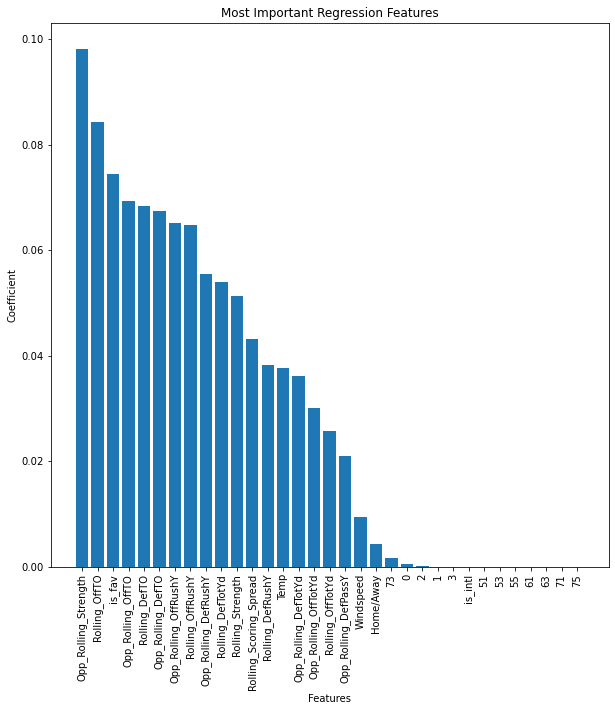

In [34]:
plt.figure(figsize=(10,10))

plt.bar(importance.sort_values(by='Importance', ascending=False)['Variable'],
                           importance.sort_values(by='Importance', ascending=False)['Importance'])

plt.title('Most Important Regression Features')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=90)

# plt.savefig('regressor_importance_chart.png')

plt.show()

In [35]:
#I'm surprised that weather has such a small impact on the model's prediction

In [245]:
#Favorites only cover the spread ~44% of the time, so I'm surprised "is_fav" has a positive coefficient
#Based on https://www.sportsoddshistory.com/nfl-game-odds/

# Random Forest Classifier

In [37]:
#Let's see how a classifier would work
#Maybe the model can't predict how well a team covers, but maybe we can predict whether or not a team covered

In [38]:
#We'll use the same data, except the y will be whether or not a team covered

In [39]:
y = np.where(reg_data['Cover'] > 0, 1, 0)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier())
])

In [42]:
cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validated Accuracy: {np.mean(cv_scores):.2f}")

Cross-validated Accuracy: 0.68


In [43]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

In [44]:
# Performance on test set
y_pred = rf_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_pred)
print(f"Validation Precision: {precision:.2f}")
recall = recall_score(y_test, y_pred)
print(f"Validation Recall: {recall:.2f}")
f1 = f1_score(y_test, y_pred)
print(f"Validation F1 Score: {f1:.2f}")

Validation Accuracy: 0.65
Validation Precision: 0.60
Validation Recall: 0.68
Validation F1 Score: 0.64


In [45]:
#Recall is quite higher than precision, so the model overestimates when teams will cover the spread

In [46]:
#Let's view an ROC Curve for the classifier

In [47]:
y_pred_prob = rf_pipeline.predict_proba(X_test)[:, 1] 

In [48]:
#Calculate teh false positive and true positive rates
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

In [49]:
#Calculate the area under the ROC curve

roc_auc = roc_auc_score(y_test, y_pred_prob) 
roc_auc

0.703122109158187

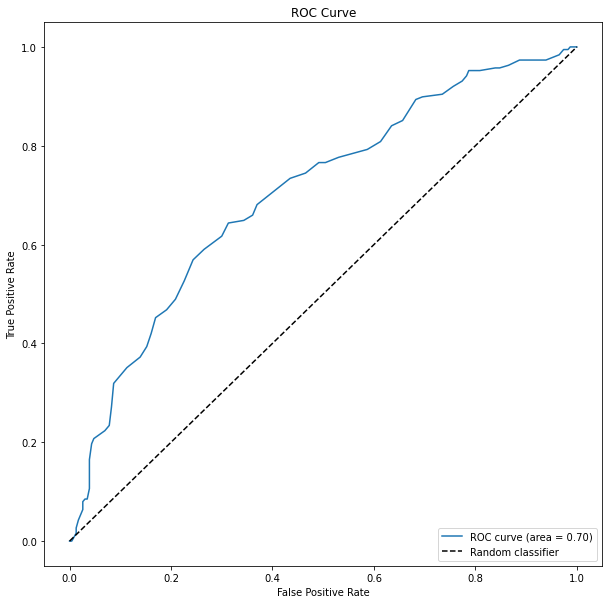

In [50]:
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) 
# roc curve for tpr = fpr  
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend(loc="lower right")
# plt.savefig('classifier_roc_curve.png')
plt.show()

In [51]:
#Our classifier is better than a random classifier, but again, there's room for improvement

# Predictions for The Upcoming Week

In [52]:
#Let's see who the model believes will cover

In [53]:
#First, let's get the data from this season

In [54]:
current_year = str(int(reg_data['Year'].max())+1)
current_year

'2023'

In [55]:
current_season_data = pd.DataFrame()

In [56]:
import time

In [57]:
team_codes = {'crd': 'Arizona Cardinals', 
              'atl': 'Atlanta Falcons', 
              'rav': 'Baltimore Ravens', 
              'buf': 'Buffalo Bills', 
              'car': 'Carolina Panthers', 
              'chi': 'Chicago Bears', 
              'cin': 'Cincinnati Bengals', 
              'cle': 'Cleveland Browns', 
              'dal': 'Dallas Cowboys', 
              'den': 'Denver Broncos', 
              'det': 'Detroit Lions', 
              'gnb': 'Green Bay Packers', 
              'htx': 'Houston Texans', 
              'clt': 'Indianapolis Colts', 
              'jax': 'Jacksonville Jaguars', 
              'kan': 'Kansas City Chiefs', 
              'rai': 'Las Vegas Raiders', 
              'sdg': 'Los Angeles Chargers', 
              'ram': 'Los Angeles Rams', 
              'mia': 'Miami Dolphins', 
              'min': 'Minnesota Vikings', 
              'nwe': 'New England Patriots', 
              'nor': 'New Orleans Saints', 
              'nyg': 'New York Giants',
              'nyj': 'New York Jets', 
              'phi': 'Philadelphia Eagles', 
              'pit': 'Pittsburgh Steelers', 
              'sfo': 'San Francisco 49ers', 
              'sea': 'Seattle Seahawks', 
              'tam': 'Tampa Bay Buccaneers',
              'oti': 'Tennessee Titans', 
              'was': 'Washington Commanders'}

In [58]:
for i in team_codes:
    team_blank = pd.DataFrame()
    url = f'https://www.pro-football-reference.com/teams/{i}/{current_year}.htm#games'
    test = pd.read_html(url)[1]
    test = test.droplevel(0,axis=1)
    test = test[:18]
    test['Team'] = team_codes[i]
    test['Year'] = current_year
    team_blank = pd.concat([team_blank,test])
    #We don't want too many requests too fast, so make the program stop before continuing.
    #Use a randint so that the scraping behavior is less predictable
    time.sleep(np.random.randint(1,4))
    current_season_data = pd.concat([current_season_data, team_blank])
    time.sleep(np.random.randint(1,4))

In [59]:
current_season = current_season_data.copy().reset_index(drop=True)

In [60]:
current_season.head()

,Week,Day,Date,Unnamed: 3_level_1,Unnamed: 4_level_1,Unnamed: 5_level_1,OT,Rec,Unnamed: 8_level_1,Opp,...,1stD,TotYd,PassY,RushY,TO,Offense,Defense,Sp. Tms,Team,Year
0,1,Sun,September 10,1:00PM ET,boxscore,L,NaN,0-1,@,Washington Commanders,...,21.0,248.0,156.0,92.0,3.0,-19.87,9.25,4.96,Arizona Cardinals,2023
1,2,Sun,September 17,4:05PM ET,boxscore,L,NaN,0-2,NaN,New York Giants,...,26.0,439.0,312.0,127.0,1.0,15.48,-16.76,-2.39,Arizona Cardinals,2023
2,3,Sun,September 24,4:25PM ET,boxscore,W,NaN,1-2,NaN,Dallas Cowboys,...,26.0,416.0,231.0,185.0,1.0,18.46,-6.78,1.14,Arizona Cardinals,2023
3,4,Sun,October 1,4:25PM ET,boxscore,L,NaN,1-3,@,San Francisco 49ers,...,30.0,395.0,271.0,124.0,NaN,9.72,-30.46,1.63,Arizona Cardinals,2023
4,5,Sun,October 8,4:05PM ET,boxscore,L,NaN,1-4,NaN,Cincinnati Bengals,...,27.0,380.0,287.0,93.0,1.0,-9.49,-4.11,-0.68,Arizona Cardinals,2023


In [61]:
current_season.index.is_unique

True

In [62]:
current_season.columns = ['Week', 'Day', 'Date', 'Time', 'boxscore',
       'Result', 'OT', 'Rec', 'Home/Away', 'Opp Name', 'Team Score',
       'Opp Score', 'Off1stD', 'OffTotYd', 'OffPassY', 'OffRushY', 'OffTO', 'Def1stD', 'DefTotYd',
       'DefPassY', 'DefRushY', 'DefTO', 'Offense', 'Defense', 'Sp. Tms', 'Team', 'Year']

In [63]:
current_season.columns

Index(['Week', 'Day', 'Date', 'Time', 'boxscore', 'Result', 'OT', 'Rec',
       'Home/Away', 'Opp Name', 'Team Score', 'Opp Score', 'Off1stD',
       'OffTotYd', 'OffPassY', 'OffRushY', 'OffTO', 'Def1stD', 'DefTotYd',
       'DefPassY', 'DefRushY', 'DefTO', 'Offense', 'Defense', 'Sp. Tms',
       'Team', 'Year'],
      dtype='object')

In [64]:
current_season = current_season.fillna(0)

In [65]:
current_season = current_season.drop(current_season[current_season['Team Score'] == 'Canceled'].index)

In [66]:
#It would be helpful to refernce a table with all the bye weeks

In [67]:
bye = current_season[current_season['Opp Name'] == 'Bye Week'][['Team', 'Week']].sort_values(by='Week')\
.reset_index(drop=True)

In [68]:
bye

,Team,Week
0,Tampa Bay Buccaneers,5
1,Los Angeles Chargers,5
2,Cleveland Browns,5
3,Seattle Seahawks,5
4,Pittsburgh Steelers,6
5,Green Bay Packers,6
6,New York Jets,7
7,Carolina Panthers,7
8,Cincinnati Bengals,7
9,Dallas Cowboys,7


In [69]:
current_season = current_season.drop(current_season[current_season['Opp Name'] == 'Bye Week'].index)

In [70]:
current_season = current_season.drop(current_season[current_season['Date'] == 'Playoffs'].index)

In [71]:
current_season['Week'] = current_season['Week'].astype('int')
current_season['Date'] = current_season['Date'].astype('str')
current_season['Time'] = current_season['Time'].astype('str')
current_season['Result'] = current_season['Result'].astype('str')
current_season['OT'] = current_season['OT'].astype('str')
current_season['Home/Away'] = current_season['Home/Away'].astype('str')
current_season['Team Score'] = current_season['Team Score'].astype('int')
current_season['Opp Score'] = current_season['Opp Score'].astype('int')
current_season['Off1stD'] = current_season['Off1stD'].astype('int')
current_season['OffTotYd'] = current_season['OffTotYd'].astype('int')
current_season['OffPassY'] = current_season['OffPassY'].astype('int')
current_season['OffRushY'] = current_season['OffRushY'].astype('int')
current_season['OffRushY'] = current_season['OffRushY'].astype('int')
current_season['OffTO'] = current_season['OffTO'].astype('int')
current_season['Def1stD'] = current_season['Def1stD'].astype('int')
current_season['DefTotYd'] = current_season['DefTotYd'].astype('int')
current_season['DefPassY'] = current_season['DefPassY'].astype('int')
current_season['DefRushY'] = current_season['DefRushY'].astype('int')
current_season['DefTO'] = current_season['DefTO'].astype('int')
current_season['Team'] = current_season['Team'].astype('str')

In [72]:
current_season['Scoring Spread'] = current_season['Team Score'] - current_season['Opp Score']

In [73]:
current_season['Home/Away'] = current_season['Home/Away'].apply(lambda x: 1 if x == '@' else 0)

In [74]:
current_season = current_season.sort_values(by=['Year', 'Team', 'Week']).reset_index(drop=True)

In [75]:
current_original_week = current_season['Week'].copy()

In [76]:
current_strength = current_season.groupby(['Team'])['Scoring Spread'].expanding(min_periods=1).sum().reset_index()

In [77]:
current_strength = current_strength.drop('level_1', axis=1)

In [78]:
current_strength['Week'] = current_original_week

In [79]:
current_strength[current_strength['Week'].isna()].head(20)

,Team,Scoring Spread,Week


In [80]:
current_strength['Strength'] = round(current_strength['Scoring Spread'] / current_strength['Week'],2)

In [81]:
current_strength[(current_strength['Team'] == 'Arizona Cardinals')]

,Team,Scoring Spread,Week,Strength
0,Arizona Cardinals,-4.0,1,-4.00
1,Arizona Cardinals,-7.0,2,-3.50
2,Arizona Cardinals,5.0,3,1.67
3,Arizona Cardinals,-14.0,4,-3.50
4,Arizona Cardinals,-28.0,5,-5.60
5,Arizona Cardinals,-45.0,6,-7.50
6,Arizona Cardinals,-45.0,7,-6.43
7,Arizona Cardinals,-45.0,8,-5.62
8,Arizona Cardinals,-45.0,9,-5.00
9,Arizona Cardinals,-45.0,10,-4.50


In [82]:
current_season = current_season.merge(current_strength, on=['Team', 'Week'], how='left').reset_index(drop=True)

In [83]:
current_season = current_season.rename(columns={'Scoring Spread_x':'Team_Scoring_Spread',
                                               'Scoring Spread_y':'Rolling_Scoring_Spread',
                                               'Strength':'Rolling_Strength'})

In [84]:
current_season.columns

Index(['Week', 'Day', 'Date', 'Time', 'boxscore', 'Result', 'OT', 'Rec',
       'Home/Away', 'Opp Name', 'Team Score', 'Opp Score', 'Off1stD',
       'OffTotYd', 'OffPassY', 'OffRushY', 'OffTO', 'Def1stD', 'DefTotYd',
       'DefPassY', 'DefRushY', 'DefTO', 'Offense', 'Defense', 'Sp. Tms',
       'Team', 'Year', 'Team_Scoring_Spread', 'Rolling_Scoring_Spread',
       'Rolling_Strength'],
      dtype='object')

In [85]:
current_season.head()

,Week,Day,Date,Time,boxscore,Result,OT,Rec,Home/Away,Opp Name,...,DefRushY,DefTO,Offense,Defense,Sp. Tms,Team,Year,Team_Scoring_Spread,Rolling_Scoring_Spread,Rolling_Strength
0,1,Sun,September 10,1:00PM ET,boxscore,L,0,0-1,1,Washington Commanders,...,92,3,-19.87,9.25,4.96,Arizona Cardinals,2023,-4,-4.0,-4.00
1,2,Sun,September 17,4:05PM ET,boxscore,L,0,0-2,0,New York Giants,...,127,1,15.48,-16.76,-2.39,Arizona Cardinals,2023,-3,-7.0,-3.50
2,3,Sun,September 24,4:25PM ET,boxscore,W,0,1-2,0,Dallas Cowboys,...,185,1,18.46,-6.78,1.14,Arizona Cardinals,2023,12,5.0,1.67
3,4,Sun,October 1,4:25PM ET,boxscore,L,0,1-3,1,San Francisco 49ers,...,124,0,9.72,-30.46,1.63,Arizona Cardinals,2023,-19,-14.0,-3.50
4,5,Sun,October 8,4:05PM ET,boxscore,L,0,1-4,0,Cincinnati Bengals,...,93,1,-9.49,-4.11,-0.68,Arizona Cardinals,2023,-14,-28.0,-5.60


In [86]:
current_rolling = current_season.groupby('Team')[['Off1stD', 'OffTotYd', 'OffPassY',
       'OffRushY', 'OffTO', 'Def1stD', 'DefTotYd', 'DefPassY', 'DefRushY',
       'DefTO']].rolling(3).mean().reset_index()

In [87]:
current_rolling = current_rolling.drop('level_1', axis=1)

In [88]:
len(current_rolling)

544

In [89]:
current_rolling['Week'] = current_original_week.astype('int')

In [90]:
#Double check that when the next team appears in the table, the data resets the "roll"
#We don't want the "rolling avg" to include values from another team 

In [91]:
current_rolling[14:20]

,Team,Off1stD,OffTotYd,OffPassY,OffRushY,OffTO,Def1stD,DefTotYd,DefPassY,DefRushY,DefTO,Week
14,Arizona Cardinals,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,16
15,Arizona Cardinals,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,17
16,Arizona Cardinals,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,18
17,Atlanta Falcons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
18,Atlanta Falcons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
19,Atlanta Falcons,18.666667,283.333333,155.0,128.333333,0.666667,18.333333,287.666667,170.0,117.666667,1.333333,3


In [92]:
current_season = current_season.merge(current_rolling, on=['Team','Week'], how='left')

In [93]:
current_season.head()

,Week,Day,Date,Time,boxscore,Result,OT,Rec,Home/Away,Opp Name,...,Off1stD_y,OffTotYd_y,OffPassY_y,OffRushY_y,OffTO_y,Def1stD_y,DefTotYd_y,DefPassY_y,DefRushY_y,DefTO_y
0,1,Sun,September 10,1:00PM ET,boxscore,L,0,0-1,1,Washington Commanders,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Sun,September 17,4:05PM ET,boxscore,L,0,0-2,0,New York Giants,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Sun,September 24,4:25PM ET,boxscore,W,0,1-2,0,Dallas Cowboys,...,19.000000,329.666667,173.333333,156.333333,0.666667,24.333333,367.666667,233.000000,134.666667,1.666667
3,4,Sun,October 1,4:25PM ET,boxscore,L,0,1-3,1,San Francisco 49ers,...,22.333333,380.333333,221.000000,159.333333,0.000000,27.333333,416.666667,271.333333,145.333333,0.666667
4,5,Sun,October 8,4:05PM ET,boxscore,L,0,1-4,0,Cincinnati Bengals,...,19.333333,352.000000,195.666667,156.333333,1.000000,27.666667,397.000000,263.000000,134.000000,0.666667


In [94]:
current_season.columns

Index(['Week', 'Day', 'Date', 'Time', 'boxscore', 'Result', 'OT', 'Rec',
       'Home/Away', 'Opp Name', 'Team Score', 'Opp Score', 'Off1stD_x',
       'OffTotYd_x', 'OffPassY_x', 'OffRushY_x', 'OffTO_x', 'Def1stD_x',
       'DefTotYd_x', 'DefPassY_x', 'DefRushY_x', 'DefTO_x', 'Offense',
       'Defense', 'Sp. Tms', 'Team', 'Year', 'Team_Scoring_Spread',
       'Rolling_Scoring_Spread', 'Rolling_Strength', 'Off1stD_y', 'OffTotYd_y',
       'OffPassY_y', 'OffRushY_y', 'OffTO_y', 'Def1stD_y', 'DefTotYd_y',
       'DefPassY_y', 'DefRushY_y', 'DefTO_y'],
      dtype='object')

In [95]:
current_season = current_season.rename(columns={'Off1stD_y':'Rolling_Off1stD',
                            'OffTotYd_y':'Rolling_OffTotYd', 
                            'OffPassY_y':'Rolling_OffPassY', 
                            'OffRushY_y':'Rolling_OffRushY', 
                            'OffTO_y':'Rolling_OffTO', 
                            'Def1stD_y':'Rolling_Def1stD',
                            'DefTotYd_y':'Rolling_DefTotYd', 
                            'DefPassY_y':'Rolling_DefPassY', 
                            'DefRushY_y':'Rolling_DefRushY', 
                            'DefTO_y':'Rolling_DefTO'})

In [96]:
current_season.iloc[:,20:30].head()

,DefRushY_x,DefTO_x,Offense,Defense,Sp. Tms,Team,Year,Team_Scoring_Spread,Rolling_Scoring_Spread,Rolling_Strength
0,92,3,-19.87,9.25,4.96,Arizona Cardinals,2023,-4,-4.0,-4.00
1,127,1,15.48,-16.76,-2.39,Arizona Cardinals,2023,-3,-7.0,-3.50
2,185,1,18.46,-6.78,1.14,Arizona Cardinals,2023,12,5.0,1.67
3,124,0,9.72,-30.46,1.63,Arizona Cardinals,2023,-19,-14.0,-3.50
4,93,1,-9.49,-4.11,-0.68,Arizona Cardinals,2023,-14,-28.0,-5.60


In [97]:
#Now let's get opponent metrics

In [98]:
current_season = current_season.merge(current_rolling, left_on=['Opp Name','Week'],
                            right_on=['Team','Week'],how='left')

In [99]:
current_season = current_season.rename(columns={'Off1stD':'Opp_Rolling_Off1stD', 
                                      'OffTotYd':'Opp_Rolling_OffTotYd', 
                                      'OffPassY':'Opp_Rolling_OffPassY',
                                      'OffRushY':'Opp_Rolling_OffRushY', 
                                      'OffTO':'Opp_Rolling_OffTO',  
                                      'Def1stD':'Opp_Rolling_Def1stD', 
                                      'DefTotYd':'Opp_Rolling_DefTotYd',
                                      'DefPassY':'Opp_Rolling_DefPassY',
                                      'DefRushY':'Opp_Rolling_DefRushY',
                                      'DefTO':'Opp_Rolling_DefTO',
                                      'Team_x':'Team'})

current_season = current_season.drop('Team_y', axis=1)

In [100]:
#Now we join in rolling opponent strength

In [101]:
current_season = current_season.merge(current_strength, 
                            left_on=['Opp Name', 'Week'], 
                            right_on=['Team', 'Week'], 
                            how='left')

In [102]:
current_season.columns

Index(['Week', 'Day', 'Date', 'Time', 'boxscore', 'Result', 'OT', 'Rec',
       'Home/Away', 'Opp Name', 'Team Score', 'Opp Score', 'Off1stD_x',
       'OffTotYd_x', 'OffPassY_x', 'OffRushY_x', 'OffTO_x', 'Def1stD_x',
       'DefTotYd_x', 'DefPassY_x', 'DefRushY_x', 'DefTO_x', 'Offense',
       'Defense', 'Sp. Tms', 'Team_x', 'Year', 'Team_Scoring_Spread',
       'Rolling_Scoring_Spread', 'Rolling_Strength', 'Rolling_Off1stD',
       'Rolling_OffTotYd', 'Rolling_OffPassY', 'Rolling_OffRushY',
       'Rolling_OffTO', 'Rolling_Def1stD', 'Rolling_DefTotYd',
       'Rolling_DefPassY', 'Rolling_DefRushY', 'Rolling_DefTO',
       'Opp_Rolling_Off1stD', 'Opp_Rolling_OffTotYd', 'Opp_Rolling_OffPassY',
       'Opp_Rolling_OffRushY', 'Opp_Rolling_OffTO', 'Opp_Rolling_Def1stD',
       'Opp_Rolling_DefTotYd', 'Opp_Rolling_DefPassY', 'Opp_Rolling_DefRushY',
       'Opp_Rolling_DefTO', 'Team_y', 'Scoring Spread', 'Strength'],
      dtype='object')

In [103]:
current_season = current_season.rename(columns={'Scoring Spread':'Opp_Scoring_Spread',
                                 'Strength':'Opp_Rolling_Strength',
                                 'Team_x':'Team'})

In [104]:
current_season = current_season.drop('Team_y', axis=1)

In [105]:
#Now it's time to join the betting data with the performance data

In [106]:
current_bet_data = pd.read_html('https://www.sportsline.com/nfl/odds/')[0]

In [107]:
current_bet = current_bet_data.copy()

In [108]:
current_bet.head()

,Matchup,Proj Score,consensus,Unnamed: 3,caesars,draftkings,fanduel,bet365newjersey
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Falcons3-3,NaN,+2.5-105Open: +2.5,+2.5-105Open: +2.5,+2.5+100Open: +2.5,+2.5-102Open: +1.5,+2.5-105Open: +2.5,+2.5-105Open: +2.5
2,Buccaneers3-2,NaN,-2.5-115Open: -2.5,-2.5-115Open: -2.5,-2.5-120Open: -2.5,-2.5-118Open: -1.5,-2.5-115Open: -2.5,-2.5-115Open: -2.5
3,"9 Expert PicksOct 22, 5:00PM UTC on FOX","9 Expert PicksOct 22, 5:00PM UTC on FOX","9 Expert PicksOct 22, 5:00PM UTC on FOX","9 Expert PicksOct 22, 5:00PM UTC on FOX","9 Expert PicksOct 22, 5:00PM UTC on FOX","9 Expert PicksOct 22, 5:00PM UTC on FOX","9 Expert PicksOct 22, 5:00PM UTC on FOX","9 Expert PicksOct 22, 5:00PM UTC on FOX"
4,Advanced Insightsloading...,Advanced Insightsloading...,Advanced Insightsloading...,Advanced Insightsloading...,Advanced Insightsloading...,Advanced Insightsloading...,Advanced Insightsloading...,Advanced Insightsloading...


In [109]:
current_bet = current_bet[['Matchup', 'consensus']]

In [110]:
current_bet['Matchup'] = current_bet['Matchup'].astype('str')
current_bet['consensus'] = current_bet['consensus'].astype('str')

In [111]:
current_bet = current_bet[current_bet['Matchup'].apply(lambda x: (len(x.split(' ')) < 2))]

In [112]:
current_bet = current_bet[current_bet['Matchup'] != 'nan']

In [113]:
current_bet['consensus'] = current_bet['consensus'].apply(lambda x: x.split('Open')[0][:-4])

In [114]:
current_bet.columns = ['Team', 'Spread']

In [115]:
current_bet = current_bet.reset_index(drop=True)

In [116]:
current_bet['Team'] = current_bet['Team'].apply(lambda x: re.sub(r'[0-9]', '', x))
current_bet['Team'] = current_bet['Team'].apply(lambda x: x.replace('-',''))

In [117]:
current_bet.head()

,Team,Spread
0,Falcons,+2.5
1,Buccaneers,-2.5
2,Bills,-7.5
3,Patriots,+7.5
4,Browns,-3.5


In [118]:
current_season['Week'] = current_season['Week'].astype('str')
current_season['Team'] = current_season['Team'].astype('str')

In [119]:
current_season.head()

,Week,Day,Date,Time,boxscore,Result,OT,Rec,Home/Away,Opp Name,...,Opp_Rolling_OffPassY,Opp_Rolling_OffRushY,Opp_Rolling_OffTO,Opp_Rolling_Def1stD,Opp_Rolling_DefTotYd,Opp_Rolling_DefPassY,Opp_Rolling_DefRushY,Opp_Rolling_DefTO,Opp_Scoring_Spread,Opp_Rolling_Strength
0,1,Sun,September 10,1:00PM ET,boxscore,L,0,0-1,1,Washington Commanders,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.00
1,2,Sun,September 17,4:05PM ET,boxscore,L,0,0-2,0,New York Giants,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-37.0,-18.50
2,3,Sun,September 24,4:25PM ET,boxscore,W,0,1-2,0,Dallas Cowboys,...,207.333333,147.000000,0.333333,15.333333,262.000000,130.666667,131.333333,2.333333,48.0,16.00
3,4,Sun,October 1,4:25PM ET,boxscore,L,0,1-3,1,San Francisco 49ers,...,259.000000,141.333333,0.000000,20.333333,299.333333,225.000000,74.333333,1.000000,67.0,16.75
4,5,Sun,October 8,4:05PM ET,boxscore,L,0,1-4,0,Cincinnati Bengals,...,222.666667,77.333333,1.000000,17.666667,328.666667,200.000000,128.666667,2.000000,-31.0,-6.20


In [120]:
current_season['Team'].unique()

array(['Arizona Cardinals', 'Atlanta Falcons', 'Baltimore Ravens',
       'Buffalo Bills', 'Carolina Panthers', 'Chicago Bears',
       'Cincinnati Bengals', 'Cleveland Browns', 'Dallas Cowboys',
       'Denver Broncos', 'Detroit Lions', 'Green Bay Packers',
       'Houston Texans', 'Indianapolis Colts', 'Jacksonville Jaguars',
       'Kansas City Chiefs', 'Las Vegas Raiders', 'Los Angeles Chargers',
       'Los Angeles Rams', 'Miami Dolphins', 'Minnesota Vikings',
       'New England Patriots', 'New Orleans Saints', 'New York Giants',
       'New York Jets', 'Philadelphia Eagles', 'Pittsburgh Steelers',
       'San Francisco 49ers', 'Seattle Seahawks', 'Tampa Bay Buccaneers',
       'Tennessee Titans', 'Washington Commanders'], dtype=object)

In [121]:
#Editing some of the team names in the betting and season table
current_bet['Team'] = np.where(current_bet['Team'] == 'ers', '49ers', current_bet['Team'])

In [122]:
#Some teams repeat because the website will have betting data for multiple weeks
current_bet = current_bet.drop_duplicates(subset=['Team'])

In [123]:
#The betting website doesn't list the full team name
#So we need to parse the team name to join the betting data

In [124]:
current_season['Team_Join'] = current_season['Team'].apply(lambda x: x.split(' ')[-1])

In [125]:
#This will join the current week's betting spread to all weeks
#This is fine b/c we'll later remove all weeks except the upcoming week anyways

In [126]:
current_season = current_season.merge(current_bet, left_on='Team_Join',right_on='Team', how='left')

In [127]:
current_season.columns

Index(['Week', 'Day', 'Date', 'Time', 'boxscore', 'Result', 'OT', 'Rec',
       'Home/Away', 'Opp Name', 'Team Score', 'Opp Score', 'Off1stD_x',
       'OffTotYd_x', 'OffPassY_x', 'OffRushY_x', 'OffTO_x', 'Def1stD_x',
       'DefTotYd_x', 'DefPassY_x', 'DefRushY_x', 'DefTO_x', 'Offense',
       'Defense', 'Sp. Tms', 'Team_x', 'Year', 'Team_Scoring_Spread',
       'Rolling_Scoring_Spread', 'Rolling_Strength', 'Rolling_Off1stD',
       'Rolling_OffTotYd', 'Rolling_OffPassY', 'Rolling_OffRushY',
       'Rolling_OffTO', 'Rolling_Def1stD', 'Rolling_DefTotYd',
       'Rolling_DefPassY', 'Rolling_DefRushY', 'Rolling_DefTO',
       'Opp_Rolling_Off1stD', 'Opp_Rolling_OffTotYd', 'Opp_Rolling_OffPassY',
       'Opp_Rolling_OffRushY', 'Opp_Rolling_OffTO', 'Opp_Rolling_Def1stD',
       'Opp_Rolling_DefTotYd', 'Opp_Rolling_DefPassY', 'Opp_Rolling_DefRushY',
       'Opp_Rolling_DefTO', 'Opp_Scoring_Spread', 'Opp_Rolling_Strength',
       'Team_Join', 'Team_y', 'Spread'],
      dtype='object')

In [128]:
current_season = current_season.drop('Team_y', axis=1)
current_season = current_season.rename(columns={'Team_x':'Team',
                                               'Spread':'Betting Spread'})

In [129]:
current_season.head()

,Week,Day,Date,Time,boxscore,Result,OT,Rec,Home/Away,Opp Name,...,Opp_Rolling_OffTO,Opp_Rolling_Def1stD,Opp_Rolling_DefTotYd,Opp_Rolling_DefPassY,Opp_Rolling_DefRushY,Opp_Rolling_DefTO,Opp_Scoring_Spread,Opp_Rolling_Strength,Team_Join,Betting Spread
0,1,Sun,September 10,1:00PM ET,boxscore,L,0,0-1,1,Washington Commanders,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.00,Cardinals,+8
1,2,Sun,September 17,4:05PM ET,boxscore,L,0,0-2,0,New York Giants,...,NaN,NaN,NaN,NaN,NaN,NaN,-37.0,-18.50,Cardinals,+8
2,3,Sun,September 24,4:25PM ET,boxscore,W,0,1-2,0,Dallas Cowboys,...,0.333333,15.333333,262.000000,130.666667,131.333333,2.333333,48.0,16.00,Cardinals,+8
3,4,Sun,October 1,4:25PM ET,boxscore,L,0,1-3,1,San Francisco 49ers,...,0.000000,20.333333,299.333333,225.000000,74.333333,1.000000,67.0,16.75,Cardinals,+8
4,5,Sun,October 8,4:05PM ET,boxscore,L,0,1-4,0,Cincinnati Bengals,...,1.000000,17.666667,328.666667,200.000000,128.666667,2.000000,-31.0,-6.20,Cardinals,+8


In [130]:
current_bet[current_bet['Team'] == 'Cardinals']

,Team,Spread
12,Cardinals,+8


In [131]:
current_season['Datetime'] = pd.to_datetime(current_season['Year']+' '+current_season['Date']+' '+current_season['Time'].str[:-5],format='%Y %B %d %H:%M')


In [132]:
current_season['Datetime'] = np.where((current_season['Time'].str[-5:-3] == 'PM') \
                                 & (current_season['Time'].str[:2] != '12'), 
                                 current_season['Datetime'] + timedelta(hours=12),
                                 current_season['Datetime'])



In [133]:
current_season['Date'] = pd.to_datetime(current_season['Year']+' '+current_season['Date'],format='%Y %B %d').dt.date

In [134]:
current_season['Time'] = current_season['Datetime'].dt.time

In [135]:
current_season['Time_Rounded'] = current_season['Datetime'].round('H')

In [136]:
current_season['Time_Rounded'] = current_season['Time_Rounded'].apply(lambda x: str(x).replace(' ', 'T')[:-3])

In [137]:
current_season.head()

,Week,Day,Date,Time,boxscore,Result,OT,Rec,Home/Away,Opp Name,...,Opp_Rolling_DefTotYd,Opp_Rolling_DefPassY,Opp_Rolling_DefRushY,Opp_Rolling_DefTO,Opp_Scoring_Spread,Opp_Rolling_Strength,Team_Join,Betting Spread,Datetime,Time_Rounded
0,1,Sun,2023-09-10,13:00:00,boxscore,L,0,0-1,1,Washington Commanders,...,NaN,NaN,NaN,NaN,4.0,4.00,Cardinals,+8,2023-09-10 13:00:00,2023-09-10T13:00
1,2,Sun,2023-09-17,16:05:00,boxscore,L,0,0-2,0,New York Giants,...,NaN,NaN,NaN,NaN,-37.0,-18.50,Cardinals,+8,2023-09-17 16:05:00,2023-09-17T16:00
2,3,Sun,2023-09-24,16:25:00,boxscore,W,0,1-2,0,Dallas Cowboys,...,262.000000,130.666667,131.333333,2.333333,48.0,16.00,Cardinals,+8,2023-09-24 16:25:00,2023-09-24T16:00
3,4,Sun,2023-10-01,16:25:00,boxscore,L,0,1-3,1,San Francisco 49ers,...,299.333333,225.000000,74.333333,1.000000,67.0,16.75,Cardinals,+8,2023-10-01 16:25:00,2023-10-01T16:00
4,5,Sun,2023-10-08,16:05:00,boxscore,L,0,1-4,0,Cincinnati Bengals,...,328.666667,200.000000,128.666667,2.000000,-31.0,-6.20,Cardinals,+8,2023-10-08 16:05:00,2023-10-08T16:00


In [138]:
current_season['Home_Team'] = np.where(current_season['Home/Away'] == 0, current_season['Team'], current_season['Opp Name'])
current_season['Away_Team'] = np.where(current_season['Home/Away'] == 1, current_season['Team'], current_season['Opp Name'])

In [139]:
#We need to grab the international games

In [140]:
url = 'https://en.wikipedia.org/wiki/NFL_International_Series'
#Lets get the London Games
london = pd.read_html(url)[1]
london['City'] = 'London'
london['State'] = 'England'
london['Designated home team'] = london['Designated home team'].astype('str')
london['Designated visitor'] = london['Designated visitor'].astype('str')
london['Year'] = london['Year'].str.replace(r'\[\d+\]', '', regex=True)
london['Designated home team'] = london['Designated home team'].str.replace(r'\[\d+\]', '', regex=True)
london['Designated visitor'] = london['Designated visitor'].str.replace(r'\[\d+\]', '', regex=True)
london['Datetime'] = pd.to_datetime(london['Year']+' '+london['Date'])
london['Datetime'] = london['Datetime'].astype('str')
#Mexico Games
mx = pd.read_html(url)[2]
#City is defined in this table
mx['State'] = 'Mexico'
mx['Year'] = mx['Year'].astype('str')
mx['Designated home team'] = mx['Designated home team'].astype('str')
mx['Designated visitor'] = mx['Designated visitor'].astype('str')
mx['Year'] = mx['Year'].str.replace(r'\[\d+\]', '', regex=True)
mx['Designated home team'] = mx['Designated home team'].str.replace(r'\[\d+\]', '', regex=True)
mx['Designated visitor'] = mx['Designated visitor'].str.replace(r'\[\d+\]', '', regex=True)
mx['Datetime'] = pd.to_datetime(mx['Year']+' '+mx['Date'])
mx['Datetime'] = mx['Datetime'].astype('str')
#Germany Games
ger = pd.read_html(url)[3]
#City is defined in this table
ger['State'] = 'Germany'
ger['Year'] = ger['Year'].astype('str')
ger['Designated home team'] = ger['Designated home team'].astype('str')
ger['Designated visitor'] = ger['Designated visitor'].astype('str')
ger['Year'] = ger['Year'].str.replace(r'\[\d+\]', '', regex=True)
ger['Designated home team'] = ger['Designated home team'].str.replace(r'\[\d+\]', '', regex=True)
ger['Designated visitor'] = ger['Designated visitor'].str.replace(r'\[\d+\]', '', regex=True)
ger['Datetime'] = pd.to_datetime(ger['Year']+' '+ger['Date'])
ger['Datetime'] = ger['Datetime'].astype('str')
intl = pd.concat([london, mx, ger])
intl['is_intl'] = 1

In [141]:
current_season = current_season.merge(intl[['Designated home team','Designated visitor',
                                  'City', 'State', 'Datetime', 'is_intl']], 
                            left_on=['Home_Team', 'Away_Team'],
                            right_on=['Designated home team', 'Designated visitor'],
                            how='left')

In [142]:
current_season.head(6)

,Week,Day,Date,Time,boxscore,Result,OT,Rec,Home/Away,Opp Name,...,Datetime_x,Time_Rounded,Home_Team,Away_Team,Designated home team,Designated visitor,City,State,Datetime_y,is_intl
0,1,Sun,2023-09-10,13:00:00,boxscore,L,0,0-1,1,Washington Commanders,...,2023-09-10 13:00:00,2023-09-10T13:00,Washington Commanders,Arizona Cardinals,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Sun,2023-09-17,16:05:00,boxscore,L,0,0-2,0,New York Giants,...,2023-09-17 16:05:00,2023-09-17T16:00,Arizona Cardinals,New York Giants,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Sun,2023-09-24,16:25:00,boxscore,W,0,1-2,0,Dallas Cowboys,...,2023-09-24 16:25:00,2023-09-24T16:00,Arizona Cardinals,Dallas Cowboys,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Sun,2023-10-01,16:25:00,boxscore,L,0,1-3,1,San Francisco 49ers,...,2023-10-01 16:25:00,2023-10-01T16:00,San Francisco 49ers,Arizona Cardinals,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Sun,2023-10-08,16:05:00,boxscore,L,0,1-4,0,Cincinnati Bengals,...,2023-10-08 16:05:00,2023-10-08T16:00,Arizona Cardinals,Cincinnati Bengals,NaN,NaN,NaN,NaN,NaN,NaN
5,6,Sun,2023-10-15,16:25:00,boxscore,L,0,1-5,1,Los Angeles Rams,...,2023-10-15 16:25:00,2023-10-15T16:00,Los Angeles Rams,Arizona Cardinals,Los Angeles Rams,Arizona Cardinals,London,England,2017-10-22,1.0


In [143]:
current_season['is_intl'] = np.where(current_season['is_intl'].isna(), 0, 1)

In [144]:
current_season = current_season.drop(['Designated home team', 'Designated visitor',
                           'Datetime_y'], axis=1)

In [145]:
current_season.head(6)

,Week,Day,Date,Time,boxscore,Result,OT,Rec,Home/Away,Opp Name,...,Opp_Rolling_Strength,Team_Join,Betting Spread,Datetime_x,Time_Rounded,Home_Team,Away_Team,City,State,is_intl
0,1,Sun,2023-09-10,13:00:00,boxscore,L,0,0-1,1,Washington Commanders,...,4.00,Cardinals,+8,2023-09-10 13:00:00,2023-09-10T13:00,Washington Commanders,Arizona Cardinals,NaN,NaN,0
1,2,Sun,2023-09-17,16:05:00,boxscore,L,0,0-2,0,New York Giants,...,-18.50,Cardinals,+8,2023-09-17 16:05:00,2023-09-17T16:00,Arizona Cardinals,New York Giants,NaN,NaN,0
2,3,Sun,2023-09-24,16:25:00,boxscore,W,0,1-2,0,Dallas Cowboys,...,16.00,Cardinals,+8,2023-09-24 16:25:00,2023-09-24T16:00,Arizona Cardinals,Dallas Cowboys,NaN,NaN,0
3,4,Sun,2023-10-01,16:25:00,boxscore,L,0,1-3,1,San Francisco 49ers,...,16.75,Cardinals,+8,2023-10-01 16:25:00,2023-10-01T16:00,San Francisco 49ers,Arizona Cardinals,NaN,NaN,0
4,5,Sun,2023-10-08,16:05:00,boxscore,L,0,1-4,0,Cincinnati Bengals,...,-6.20,Cardinals,+8,2023-10-08 16:05:00,2023-10-08T16:00,Arizona Cardinals,Cincinnati Bengals,NaN,NaN,0
5,6,Sun,2023-10-15,16:25:00,boxscore,L,0,1-5,1,Los Angeles Rams,...,3.50,Cardinals,+8,2023-10-15 16:25:00,2023-10-15T16:00,Los Angeles Rams,Arizona Cardinals,London,England,1


In [146]:
#Let's get stadium data
#So we can get the location of each game being played

In [147]:
stadiums = pd.DataFrame(pd.read_html('https://geojango.com/pages/list-of-nfl-teams')[0])
stadiums.loc[len(stadiums)] = ['Washington Football Team', 'FedExField', 'Landover, Maryland', 82000, 1997]
stadiums['City'] = stadiums['Arena Location'].apply(lambda x: x.split(', ')[0])
stadiums['State'] = stadiums['Arena Location'].apply(lambda x: x.split(', ')[1])

In [148]:
current_season = current_season.merge(stadiums, left_on='Home_Team', right_on='Team Name')

In [149]:
#We'll condense the information from our international table and stadiums table into one

In [150]:
current_season['City'] = np.where(current_season['City_x'].isna(), current_season['City_y'], current_season['City_x'])
current_season['State'] = np.where(current_season['State_x'].isna(), current_season['State_y'], current_season['State_x'])

In [151]:
current_season = current_season.drop(['City_x', 'City_y', 'State_x', 'State_y', 'Team Name', 'Arena Name', 'Arena Location',
               'Seating Capacity', 'Opening Year'], axis=1)

In [152]:
current_season = current_season.rename(columns={'Datetime_x':'Datetime'})

In [153]:
#Lastly, make any international game a away game
#But make sure that any away game already listed as away is still listed as away

In [154]:
current_season['Home/Away'] = np.where((current_season['is_intl'] == 1) | (current_season['Home/Away'] == 1), 1, 0)

In [155]:
#So we can order the data by week
current_season['Week'] = current_season['Week'].astype('int')

In [156]:
current_season = current_season.sort_values(by=['Team', 'Week'])

In [157]:
#We need to shift all the performance data down a row
#So that the latest row has the upcoming week's info with the previous performance

In [158]:
current_season.columns

Index(['Week', 'Day', 'Date', 'Time', 'boxscore', 'Result', 'OT', 'Rec',
       'Home/Away', 'Opp Name', 'Team Score', 'Opp Score', 'Off1stD_x',
       'OffTotYd_x', 'OffPassY_x', 'OffRushY_x', 'OffTO_x', 'Def1stD_x',
       'DefTotYd_x', 'DefPassY_x', 'DefRushY_x', 'DefTO_x', 'Offense',
       'Defense', 'Sp. Tms', 'Team', 'Year', 'Team_Scoring_Spread',
       'Rolling_Scoring_Spread', 'Rolling_Strength', 'Rolling_Off1stD',
       'Rolling_OffTotYd', 'Rolling_OffPassY', 'Rolling_OffRushY',
       'Rolling_OffTO', 'Rolling_Def1stD', 'Rolling_DefTotYd',
       'Rolling_DefPassY', 'Rolling_DefRushY', 'Rolling_DefTO',
       'Opp_Rolling_Off1stD', 'Opp_Rolling_OffTotYd', 'Opp_Rolling_OffPassY',
       'Opp_Rolling_OffRushY', 'Opp_Rolling_OffTO', 'Opp_Rolling_Def1stD',
       'Opp_Rolling_DefTotYd', 'Opp_Rolling_DefPassY', 'Opp_Rolling_DefRushY',
       'Opp_Rolling_DefTO', 'Opp_Scoring_Spread', 'Opp_Rolling_Strength',
       'Team_Join', 'Betting Spread', 'Datetime', 'Time_Rounded', 'Home

In [159]:
current_season['Rolling_Scoring_Spread'] = current_season['Rolling_Scoring_Spread'].shift(1)
current_season['Rolling_Strength'] = current_season['Rolling_Strength'].shift(1)
current_season['Opp_Rolling_Strength'] = current_season['Opp_Rolling_Strength'].shift(1)
current_season['Rolling_Off1stD'] = current_season['Rolling_Off1stD'].shift(1)
current_season['Rolling_OffTotYd'] = current_season['Rolling_OffTotYd'].shift(1)
current_season['Rolling_OffPassY'] = current_season['Rolling_OffPassY'].shift(1)
current_season['Rolling_OffRushY'] = current_season['Rolling_OffRushY'].shift(1)
current_season['Rolling_OffTO'] = current_season['Rolling_OffTO'].shift(1)
current_season['Rolling_Def1stD'] = current_season['Rolling_Def1stD'].shift(1)
current_season['Rolling_DefTotYd'] = current_season['Rolling_DefTotYd'].shift(1)
current_season['Rolling_DefPassY'] = current_season['Rolling_DefPassY'].shift(1)
current_season['Rolling_DefRushY'] = current_season['Rolling_DefRushY'].shift(1)
current_season['Rolling_DefTO'] = current_season['Rolling_DefTO'].shift(1)
current_season['Opp_Rolling_Off1stD'] = current_season['Opp_Rolling_Off1stD'].shift(1)
current_season['Opp_Rolling_OffTotYd'] = current_season['Opp_Rolling_OffTotYd'].shift(1)
current_season['Opp_Rolling_OffPassY'] = current_season['Opp_Rolling_OffPassY'].shift(1)
current_season['Opp_Rolling_OffRushY'] = current_season['Opp_Rolling_OffRushY'].shift(1)
current_season['Opp_Rolling_OffTO'] = current_season['Opp_Rolling_OffTO'].shift(1)
current_season['Opp_Rolling_OffTotYd'] = current_season['Opp_Rolling_OffTotYd'].shift(1)
current_season['Opp_Rolling_Off1stD'] = current_season['Opp_Rolling_Def1stD'].shift(1)
current_season['Opp_Rolling_DefTotYd'] = current_season['Opp_Rolling_DefTotYd'].shift(1)
current_season['Opp_Rolling_DefPassY'] = current_season['Opp_Rolling_DefPassY'].shift(1)
current_season['Opp_Rolling_DefRushY'] = current_season['Opp_Rolling_DefRushY'].shift(1)
current_season['Opp_Rolling_DefTO'] = current_season['Opp_Rolling_DefTO'].shift(1)

In [160]:
upcoming = current_season[current_season['Result'] == '0'].groupby('Team').first().reset_index()

In [161]:
upcoming['Week'] = upcoming['Week'].astype('str')

In [162]:
#The "upcoming" games for those on bye will be 1 week greater than the current week
#So we can remove those on "bye" by keeping those with the week that's the smallest

In [163]:
upcoming = upcoming[upcoming['Week'] == upcoming['Week'].min()].copy()

In [164]:
upcoming.head()

,Team,Week,Day,Date,Time,boxscore,Result,OT,Rec,Home/Away,...,Opp_Rolling_Strength,Team_Join,Betting Spread,Datetime,Time_Rounded,Home_Team,Away_Team,is_intl,City,State
0,Arizona Cardinals,7,Sun,2023-10-22,16:05:00,preview,0,0,0,1,...,3.50,Cardinals,+8,2023-10-22 16:05:00,2023-10-22T16:00,Seattle Seahawks,Arizona Cardinals,0,Seattle,Washington
1,Atlanta Falcons,7,Sun,2023-10-22,13:00:00,preview,0,0,0,1,...,-7.17,Falcons,+2.5,2023-10-22 13:00:00,2023-10-22T13:00,Tampa Bay Buccaneers,Atlanta Falcons,0,Tampa,Florida
2,Baltimore Ravens,7,Sun,2023-10-22,13:00:00,preview,0,0,0,0,...,-2.17,Ravens,-3,2023-10-22 13:00:00,2023-10-22T13:00,Baltimore Ravens,Detroit Lions,0,Baltimore,Maryland
3,Buffalo Bills,7,Sun,2023-10-22,13:00:00,preview,0,0,0,1,...,-16.00,Bills,-7.5,2023-10-22 13:00:00,2023-10-22T13:00,New England Patriots,Buffalo Bills,0,Foxborough,Massachusetts
5,Chicago Bears,7,Sun,2023-10-22,13:00:00,preview,0,0,0,0,...,-1.00,Bears,+2.5,2023-10-22 13:00:00,2023-10-22T13:00,Chicago Bears,Las Vegas Raiders,0,Chicago,Illinois


In [165]:
len(upcoming)

24

In [166]:
#To get weather, I'll pass the cities through an API via openweathermap.org
#Free 1000 API calls/day, after which is $1.50/1k API calls

In [167]:
#Notice that the API link is different
#Before, we used historical weather, vs now we're looking for forecasted weather

In [168]:
%store -r api_key

In [169]:
#Once we have the lat/lon for each location, we get the weather via openweathermap api (using an API key from above)
#In the US, some city names are the same across states, so we make the function below to choose the right one

def state_finder(x):
    for i in range(len(x)):
        if x[i]['state'] == state:
            return i

In [170]:
#We'll then need a function that gets the weather at the "rounded" time the game starts

def time_finder(x):
    for i in range(len(x['hourly']['time'])):
        if x['hourly']['time'][i] == time:
            return i

In [171]:
data_weather = []
for city, state, date, time, team, year, week, is_intl in zip(upcoming['City'], 
                                   upcoming['State'],
                                   upcoming['Date'],
                                   upcoming['Time_Rounded'],
                                   upcoming['Team'],
                                   upcoming['Year'],
                                   upcoming['Week'],
                                   upcoming['is_intl']):
    try:
        coordinates = r.get(f'http://api.openweathermap.org/geo/1.0/direct?q={city}, {state}&limit=10&appid={api_key}').json()
        if is_intl == 0:
            index = state_finder(coordinates)
            lat = coordinates[index]['lat']
            lon = coordinates[index]['lon']
            weather = r.get(f'https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&hourly=temperature_2m,weathercode,windspeed_10m&temperature_unit=fahrenheit&timezone=America%2FNew_York&start_date={date}&end_date={date}').json()
            index = time_finder(weather)
            temp = weather['hourly']['temperature_2m'][index]
            weather_code = weather['hourly']['weathercode'][index]
            windspeed = weather['hourly']['windspeed_10m'][index]
            data_weather.append([team, year, week, city, state, temp, weather_code, windspeed])
        else:
            index = 0
            lat = coordinates[index]['lat']
            lon = coordinates[index]['lon']
            weather = r.get(f'https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&hourly=temperature_2m,weathercode,windspeed_10m&temperature_unit=fahrenheit&timezone=America%2FNew_York&start_date={date}&end_date={date}').json()
            index = time_finder(weather)
            temp = weather['hourly']['temperature_2m'][index]
            weather_code = weather['hourly']['weathercode'][index]
            windspeed = weather['hourly']['windspeed_10m'][index]
            data_weather.append([team, year, week, city, state, temp, weather_code, windspeed])
    except Exception as e:
        continue

In [172]:
len(data_weather)

24

In [173]:
current_weather = pd.DataFrame(data_weather, columns = ['Team', 'Year', 'Week', 'City', 'State', 'Temp', 'Weather Code', 'Windspeed'])





In [174]:
#Checking we don't have any n/a games

current_weather[current_weather['Temp'].isna()]

,Team,Year,Week,City,State,Temp,Weather Code,Windspeed


In [175]:
current_weather.head()

,Team,Year,Week,City,State,Temp,Weather Code,Windspeed
0,Arizona Cardinals,2023,7,Seattle,Washington,57.3,3,6.4
1,Atlanta Falcons,2023,7,Tampa,Florida,84.9,3,6.8
2,Baltimore Ravens,2023,7,Baltimore,Maryland,57.2,1,27.0
3,Buffalo Bills,2023,7,Foxborough,Massachusetts,50.5,2,22.4
4,Chicago Bears,2023,7,Chicago,Illinois,48.8,3,9.9


In [176]:
#We pulled in weather code, which we will breakout
#https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM

In [177]:
#These codes indicate the type of weather being experienced
#So we need a binary 0/1 column for each weather type

In [178]:
weather_type = pd.get_dummies(current_weather['Weather Code'])

In [179]:
current_weather = pd.concat([current_weather, weather_type], axis=1)

In [180]:
#Let's join the weather data to team performance data

In [181]:
upcoming = upcoming.merge(current_weather, on=['Year','Team', 'Week'], how='left')

In [182]:
upcoming = upcoming.drop(['City_y', 'State_y'], axis=1)
upcoming = upcoming.rename(columns={'City_x':'City',
                                     'State_x':'State'})

In [183]:
upcoming['Betting Spread'] = np.where(upcoming['Betting Spread'] == 'PK', 0, upcoming['Betting Spread'])

In [184]:
upcoming['Betting Spread'] = upcoming['Betting Spread'].astype('float')

In [185]:
#The upcoming week won't have all the weather codes that the regression was trained on
#So for the model to provide estimates, we'll need to add columns of weather codes not in the upcoming week

upcoming.columns = [str(i) for i in upcoming.columns]
current_codes = [i for i in upcoming.columns if ((len(i)) <=2) & (str(i) != 'OT')]
current_codes

['0', '1', '2', '3']

In [186]:
model_codes = [i for i in reg_data.columns if (len(str(i)) <=2) & (str(i) != 'OT')]
model_codes

['0', '1', '2', '3', '51', '53', '55', '61', '63', '71', '73', '75']

In [187]:
for i in model_codes:
    if i in current_codes:
        pass
    else:
        upcoming[i] = 0

In [188]:
#Check that all weather codes are in the upcoming dataframe

upcoming.columns

Index(['Team', 'Week', 'Day', 'Date', 'Time', 'boxscore', 'Result', 'OT',
       'Rec', 'Home/Away', 'Opp Name', 'Team Score', 'Opp Score', 'Off1stD_x',
       'OffTotYd_x', 'OffPassY_x', 'OffRushY_x', 'OffTO_x', 'Def1stD_x',
       'DefTotYd_x', 'DefPassY_x', 'DefRushY_x', 'DefTO_x', 'Offense',
       'Defense', 'Sp. Tms', 'Year', 'Team_Scoring_Spread',
       'Rolling_Scoring_Spread', 'Rolling_Strength', 'Rolling_Off1stD',
       'Rolling_OffTotYd', 'Rolling_OffPassY', 'Rolling_OffRushY',
       'Rolling_OffTO', 'Rolling_Def1stD', 'Rolling_DefTotYd',
       'Rolling_DefPassY', 'Rolling_DefRushY', 'Rolling_DefTO',
       'Opp_Rolling_Off1stD', 'Opp_Rolling_OffTotYd', 'Opp_Rolling_OffPassY',
       'Opp_Rolling_OffRushY', 'Opp_Rolling_OffTO', 'Opp_Rolling_Def1stD',
       'Opp_Rolling_DefTotYd', 'Opp_Rolling_DefPassY', 'Opp_Rolling_DefRushY',
       'Opp_Rolling_DefTO', 'Opp_Scoring_Spread', 'Opp_Rolling_Strength',
       'Team_Join', 'Betting Spread', 'Datetime', 'Time_Rounded', 'Home

In [189]:
upcoming.head()

,Team,Week,Day,Date,Time,boxscore,Result,OT,Rec,Home/Away,...,2,3,51,53,55,61,63,71,73,75
0,Arizona Cardinals,7,Sun,2023-10-22,16:05:00,preview,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,Atlanta Falcons,7,Sun,2023-10-22,13:00:00,preview,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,Baltimore Ravens,7,Sun,2023-10-22,13:00:00,preview,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Buffalo Bills,7,Sun,2023-10-22,13:00:00,preview,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,Chicago Bears,7,Sun,2023-10-22,13:00:00,preview,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [190]:
upcoming['is_fav'] = np.where(upcoming['Betting Spread'] < 0, 1, 0)

In [191]:
#Let's extract the features, and pass this through out regression models

In [192]:
upcoming_features = upcoming[[i for i in X.columns]]

In [193]:
#Get predictions from each model

upcoming['reg_prediction'] = reg_pipeline.predict(upcoming_features)
upcoming['rf_prediction'] = rf_pipeline.predict(upcoming_features)

In [194]:
#Below we see for each team:
#Team Name
#They're point spread for the upcoming week
#What the Gradient Boosted Model predicts they're cover will be (betting spread + scoring spread)
#The random forest's prediction of whether or not the team will cover

upcoming[['Team', 'Opp Name', 'Betting Spread','reg_prediction', 'rf_prediction']]

,Team,Opp Name,Betting Spread,reg_prediction,rf_prediction
0,Arizona Cardinals,Seattle Seahawks,8.0,-2.007626,0
1,Atlanta Falcons,Tampa Bay Buccaneers,2.5,3.433785,0
2,Baltimore Ravens,Detroit Lions,-3.0,6.764644,1
3,Buffalo Bills,New England Patriots,-7.5,-1.350604,0
4,Chicago Bears,Las Vegas Raiders,2.5,1.883671,1
5,Cleveland Browns,Indianapolis Colts,-3.5,-8.205775,0
6,Denver Broncos,Green Bay Packers,1.0,-8.940595,0
7,Detroit Lions,Baltimore Ravens,3.0,16.273744,1
8,Green Bay Packers,Denver Broncos,-1.0,-7.929322,0
9,Indianapolis Colts,Cleveland Browns,3.5,-1.906697,0


In [195]:
#I'm curious when my two models contradict themselves

avoid = upcoming[((upcoming['rf_prediction'] == 1) & (upcoming['reg_prediction'] < 0)
          |
          (upcoming['rf_prediction'] == 0) & (upcoming['reg_prediction'] > 0)
         )][['Team', 'Opp Name', 'Betting Spread','reg_prediction', 'rf_prediction']].reset_index(drop=True)

avoid

,Team,Opp Name,Betting Spread,reg_prediction,rf_prediction
0,Atlanta Falcons,Tampa Bay Buccaneers,2.5,3.433785,0
1,Minnesota Vikings,San Francisco 49ers,7.0,5.959484,0
2,Pittsburgh Steelers,Los Angeles Rams,3.0,1.326927,0
3,Washington Commanders,New York Giants,-3.0,-2.453829,1


In [196]:
#I may elect to avoid these games
#Let's filter to where the two models agree

In [197]:
avoid_teams = [i for i in avoid['Team'].unique()] + [i for i in avoid['Opp Name'].unique()]

In [198]:
upcoming = upcoming[~upcoming['Team'].isin(avoid_teams)]

In [199]:
upcoming[['Team', 'Opp Name', 'Betting Spread','reg_prediction', 'rf_prediction']]\
.sort_values(by='reg_prediction', ascending=False).reset_index(drop=True)

,Team,Opp Name,Betting Spread,reg_prediction,rf_prediction
0,Detroit Lions,Baltimore Ravens,3.0,16.273744,1
1,Miami Dolphins,Philadelphia Eagles,3.0,11.422130,1
2,Kansas City Chiefs,Los Angeles Chargers,-5.5,8.999746,1
3,Los Angeles Chargers,Kansas City Chiefs,5.5,7.616012,1
4,Baltimore Ravens,Detroit Lions,-3.0,6.764644,1
5,Las Vegas Raiders,Chicago Bears,-2.5,6.439558,1
6,Chicago Bears,Las Vegas Raiders,2.5,1.883671,1
7,Seattle Seahawks,Arizona Cardinals,-8.0,0.600021,1
8,Buffalo Bills,New England Patriots,-7.5,-1.350604,0
9,Indianapolis Colts,Cleveland Browns,3.5,-1.906697,0


In [200]:
#Let's see the teams that have a regression prediction greater than the abs(rmse)

In [201]:
upcoming[np.abs(upcoming['reg_prediction']) >= rmse][['Team', 'Opp Name', 'Betting Spread','reg_prediction', 'rf_prediction']]\
.sort_values(by='reg_prediction', ascending=False).reset_index(drop=True)

,Team,Opp Name,Betting Spread,reg_prediction,rf_prediction
0,Detroit Lions,Baltimore Ravens,3.0,16.273744,1
1,Miami Dolphins,Philadelphia Eagles,3.0,11.422130,1


In [202]:
#Theoretically these are the matchups that, given the RMSE of the regression, should be taken